# Setup

In [1]:
%matplotlib inline

import numpy as np
import scipy.signal as sig
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import datetime
import pandas as pd

from pandas import DataFrame,Series,read_table

General info

In [2]:
savePlots = True    # whether or not to save plots
saveData = True # whether or not to save csv files

saveAsPath = './Fig 02/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)
saveAsName = ''

In [3]:
#path = '/Users/svcanavan/Dropbox/Coding in progress/00_BudgieSleep/Data_copies/'

birdPaths =    ['../data_copies/01_PreprocessedData/01_BudgieFemale_green1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/05_BudgieFemale_green2/00_Baseline_night/']

arfFilePaths =  ['EEG 2 scored/',
                 'EEG 3 scored/',
                 'EEG 3 scored/',
                 'EEG 4 scored/',
                 'EEG 4 scored/']

### load BEST EEG channels - as determined during manual scoring ####
channelsToLoadEEG_best = [['6 LEEGm-LEEGp', '5 LEEGf-LEEGp'], #, '9 REEGp-LEEGp'], # extra channel to represent R hemisphere
                     ['5 LEEGf-LEEGm', '4 LEEGf-Fgr'], #, '9 REEGf-REEGm'], # extra channel to represent R hemisphere
                     ['9REEGm-REEGp', '4LEEGf-LEEGp'], 
                     ['6LEEGm-LEEGf', '9REEGf-REEGp'], 
                     ['7REEGf-REEGp', '4LEEGf-LEEGp']]


### load ALL of EEG channels ####
channelsToLoadEEG = [['4 LEEGf-Fgr', '5 LEEGf-LEEGp', '6 LEEGm-LEEGp', '7 LEEGp-Fgr', '8 REEGp-Fgr','9 REEGp-LEEGp'],
                     ['4 LEEGf-Fgr','5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '7 REEGf-Fgr', '8 REEGm-Fgr', '9 REEGf-REEGm'],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp'],
                     ['4LEEGf-LEEGp', '5LEEGm-LEEGp', '6LEEGm-LEEGf', '7REEGf-Fgr', '8REEGf-REEGm','9REEGf-REEGp',],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp']]


channelsToLoadEOG = [['1 LEOG-Fgr', '2 REOG-Fgr'],
                     ['2 LEOG-Fgr', '3 REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr']]

birds_LL = [1,2,3]
nBirds_LL = len(birds_LL)

birdPaths_LL = ['../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/01_Constant_light/',]

arfFilePaths_LL =  ['EEG 2 preprocessed/',
                    'EEG 2 preprocessed/',
                    'EEG 2 preprocessed/']

lightsOffSec = np.array([7947, 9675, 9861 + 8*3600, 9873, 13467])  # lights off times in seconds from beginning of file
lightsOnSec = np.array([46449, 48168, 48375+ 8*3600, 48381, 52005]) # Bird 3 gets 8 hours added b/c file starts at 8:00 instead of 16:00

epochLength = 3
sr = 200
scalingFactor = (2**15)*0.195       # scaling/conversion factor from amplitude to uV (when recording arf from jrecord)

stages = ['w','d','u','i','s','r'] # wake, drowsy, unihem sleep, intermediate sleep, SWS, REM
stagesSleep =    ['u','i','s','r']

stagesVideo = ['m','q','d','s','u'] # moving wake, quiet wake, drowsy, sleep, unclear

## Path to scores formatted as CSVs
formatted_scores_path = '../formatted_scores/'

## Path to detect SW ands EM events: use folder w/ EMs and EM artifacts detected during non-sleep
events_path = '../data_copies/SWs_EMs_and_EMartifacts/'

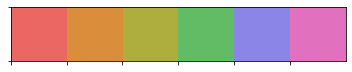

In [4]:
colors = sns.color_palette(np.array([[234,103,99],
[218,142,60],
[174,174,62],
[97,188,101],
[140,133,232],
[225,113,190]])
/255)

sns.palplot(colors)

# colorpalette from iWantHue

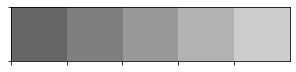

In [5]:
colors_birds = [np.repeat(.4, 3),
                np.repeat(.5, 3),
                np.repeat(.6, 3),
                np.repeat(.7, 3),
                np.repeat(.8, 3)]

sns.palplot(colors_birds)


Plot-specific info

In [6]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")
axis_label_fontsize = 24

# Markers for legends of EEG scoring colors
legendMarkersEEG = []
for stage in range(len(stages)):
    legendMarkersEEG.append(plt.Line2D([0],[0], color=colors[stage], marker='o', linestyle='', alpha=0.7))  

Calculate general variables

In [7]:
lightsOffEp = lightsOffSec / epochLength
lightsOnEp = lightsOnSec / epochLength

nBirds = len(birdPaths)

epochLengthPts = epochLength*sr

nStages = len(stagesSleep)

## Read in files

### Load formatted scores

In [8]:
AllScores = {}
for b in range(nBirds):
    bird_name = 'Bird ' + str(b+1)
    file = formatted_scores_path + 'All_scores_' + bird_name + '.csv'
    data = pd.read_csv(file, index_col=0)
    AllScores[bird_name] = data

## Calculate lights off in Zeitgeber time (s and hrs)
Lights on is 0 

In [9]:
lightsOffDatetime = np.array([], dtype='datetime64')
lightsOnDatetime = np.array([], dtype='datetime64')

for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name]
    startDatetime = np.datetime64(Scores.index.values[0])

    # Calc lights off & on using datetime formats
    lightsOffTimedelta = lightsOffSec[b_num].astype('timedelta64[s]')
    lightsOffDatetime = np.append(lightsOffDatetime, startDatetime + lightsOffTimedelta)
    lightsOnTimedelta = lightsOnSec[b_num].astype('timedelta64[s]')
    lightsOnDatetime = np.append(lightsOnDatetime, startDatetime + lightsOnTimedelta)

In [10]:
lightsOffZeit_s = lightsOffSec - lightsOnSec
lightsOffZeit_hr = lightsOffZeit_s / 3600

# NIGHTTIME SLEEP

In [11]:
AllStageProportions_by_stage = {}

## Nighttime sleep: Make table (both % of time and %TST)

In [12]:
stageProportions_night_all = {}

for b in range(nBirds):

    stageProportions = DataFrame([], columns=range(len(stages)))

    b_name = 'Bird ' + str(b+1)
    Scores = AllScores[b_name]

    start = str(lightsOffDatetime[b]).replace('T', ' ')
    end = str(lightsOnDatetime[b]).replace('T', ' ')

    bn_scores = Scores[start:end]
    bn_stage_frequencies = bn_scores['Label (#)'].value_counts(normalize=True,sort=False)
                
    stageProportions = stageProportions.append(bn_stage_frequencies, ignore_index=True)
    
    # Replace NaNs with 0
    stageProportions = stageProportions.fillna(0)
    
    # Calc TST and sleep stages as % TST
    
    stageProportions['TST'] = stageProportions[[2,3,4,5]].sum(axis=1)

    stageProportions['U (% TST)'] = stageProportions[2]/stageProportions['TST']
    stageProportions['I (% TST)'] = stageProportions[3]/stageProportions['TST']
    stageProportions['S (% TST)'] = stageProportions[4]/stageProportions['TST']
    stageProportions['R (% TST)'] = stageProportions[5]/stageProportions['TST']

    # Add to dictionary
    stageProportions_night_all[b] = stageProportions
    

## Organize proportions by stage (instead of by bird)

In [13]:
stageProportions_by_stage = {}

stage_labels = stageProportions_night_all[0].columns.values

for st in stage_labels:
    stageProportions_stage = DataFrame([])
    
    for b in range(nBirds):
        stageProportions_bird = stageProportions_night_all[b]
        stageProportions_stage['Bird ' + str(b+1)] = stageProportions_bird[st]
        
    stageProportions_by_stage[st] = stageProportions_stage

In [14]:
# Save to dict
AllStageProportions_by_stage['night'] = stageProportions_by_stage

## Find means and SDs

In [15]:
Means = DataFrame([])
SDs = DataFrame([])

for st in stage_labels:
    tmp_mean = stageProportions_by_stage[st].mean(axis=1)
    tmp_sd = stageProportions_by_stage[st].std(axis=1)
    
    Means[st] = tmp_mean
    SDs[st] = tmp_sd
    

In [16]:
Means*100

,0,1,2,3,4,5,TST,U (% TST),I (% TST),S (% TST),R (% TST)
0,11.975591,5.090544,0.02338,42.241249,15.704202,24.963475,82.932306,0.027828,50.437188,18.856059,30.678924


In [17]:
SDs*100

,0,1,2,3,4,5,TST,U (% TST),I (% TST),S (% TST),R (% TST)
0,6.335167,1.621297,0.019095,11.19485,5.097742,7.939584,6.87754,0.023303,10.214977,5.646341,11.521843


## Bar graphs: Plot each stage

In [18]:
figsize = (6,6)
axis_label_fontsize = 24
smaller_label_fontsize = 20

# Line formatting
linewidth = 5
linealpha = .7
marker = 'o'
markersize = 10
err_capsize = 3
err_capthick = 3
elinewidth = 3

# Bar formatting
bar_linewidth = 4

### FIGURE 2E

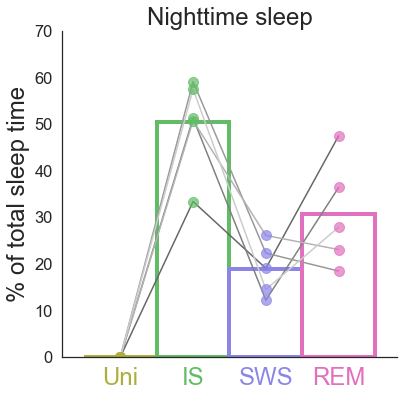

In [19]:
plt.figure(figsize=figsize)
stages_to_plot = ['U (% TST)', 'I (% TST)', 'S (% TST)', 'R (% TST)']


# Line plot of each bird
for bird in range(nBirds):
    bird_stage_proportions = np.ndarray.flatten(stageProportions_night_all[bird][stages_to_plot].values)
    plt.plot([1,2,3,4], bird_stage_proportions*100,
             color=colors_birds[bird]) 
    
num=1
for st in stages_to_plot:

    
    # Dots for each point - color by stage
    plt.plot(num, stageProportions_by_stage[st]*100,
             marker=marker, markersize=markersize,
             color=colors[2:6][num-1], alpha=linealpha)
    
    # Bar graph of mean
    plt.bar(num, Means[st]*100, width=1, color='none', edgecolor=colors[2:6][num-1], linewidth=bar_linewidth)
    
    num=num+1
    
plt.ylim(-.05, 70)
plt.xlim(.2,4.8)
plt.ylabel('% of total sleep time', fontsize=axis_label_fontsize)
plt.xticks([1, 2, 3, 4], ['Uni', 'IS', 'SWS', 'REM'],fontsize=axis_label_fontsize)
ax = plt.gca()
[t.set_color(i) for (i,t) in zip(colors[2:6],ax.xaxis.get_ticklabels())]

plt.title('Nighttime sleep', fontsize=axis_label_fontsize)
sns.despine()
    
if savePlots:
        plt.savefig(saveAsPath + saveAsName + "Fig2e_Nighttime_percentTST.pdf")

In [20]:
Means[['U (% TST)', 'I (% TST)', 'S (% TST)', 'R (% TST)']]*100

,U (% TST),I (% TST),S (% TST),R (% TST)
0,0.027828,50.437188,18.856059,30.678924


In [21]:
SDs[['U (% TST)', 'I (% TST)', 'S (% TST)', 'R (% TST)']]*100

,U (% TST),I (% TST),S (% TST),R (% TST)
0,0.023303,10.214977,5.646341,11.521843


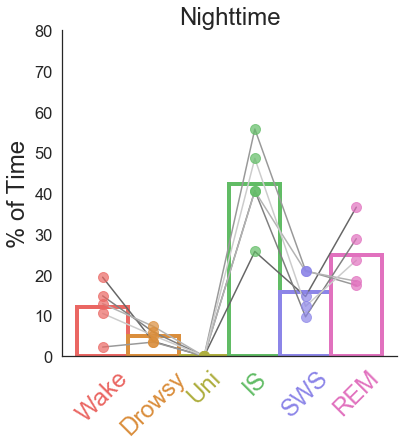

In [22]:
plt.figure(figsize=figsize)

stages_to_plot = [0,1,2,3,4,5]


# Line plot of each bird
for bird in range(nBirds):
    bird_stage_proportions = np.ndarray.flatten(stageProportions_night_all[bird][stages_to_plot].values)
    plt.plot([1,2,3,4,5,6], bird_stage_proportions*100,
             color=colors_birds[bird]) 

num=1
for st in stages_to_plot:
    # Line plot of each bird
    plt.plot(num, stageProportions_by_stage[st]*100,
             marker=marker, markersize=markersize,
             color=colors[num-1], alpha=linealpha)
    
    # Bar graph of mean
    plt.bar(num, Means[st]*100, width=1, color='none', edgecolor=colors[num-1], linewidth=bar_linewidth)
    
    num=num+1
    
plt.ylim(-.05, 80)
plt.xlim(.2, 6.8)
plt.ylabel('% of Time', fontsize=axis_label_fontsize)
plt.xticks([1, 2, 3, 4, 5, 6], ['Wake', 'Drowsy', 'Uni', 'IS', 'SWS', 'REM'],
           fontsize=axis_label_fontsize,rotation=45)

ax = plt.gca()
[t.set_color(i) for (i,t) in zip(colors,ax.xaxis.get_ticklabels())]

plt.title('Nighttime', fontsize=axis_label_fontsize)
sns.despine()
    
if savePlots:
        plt.savefig(saveAsPath + saveAsName + "Fig2e-g_Nighttime_percentTime.pdf")

In [23]:
Means[[0,1,2,3,4,5]]*100

,0,1,2,3,4,5
0,11.975591,5.090544,0.02338,42.241249,15.704202,24.963475


In [24]:
SDs[[0,1,2,3,4,5]]*100

,0,1,2,3,4,5
0,6.335167,1.621297,0.019095,11.19485,5.097742,7.939584


In [25]:
Means['TST']*100

0    82.932306
Name: TST, dtype: float64

In [26]:
SDs['TST']*100

0    6.87754
Name: TST, dtype: float64

# DAYTIME SLEEP

In [27]:
stageProportions_day_all = {}

for b in range(nBirds):

    stageProportions = DataFrame([], columns=range(len(stages)))

    b_name = 'Bird ' + str(b+1) 
    Scores = AllScores[b_name]

    first_start_ep = 0
    first_end_ep   = int(lightsOffEp[b])
    second_start_ep = int(lightsOnEp[b])

    bn_scores = Scores[first_start_ep:first_end_ep].append(Scores[second_start_ep::])
    bn_stage_frequencies = bn_scores['Label (#)'].value_counts(normalize=True,sort=False)
                
    stageProportions = stageProportions.append(bn_stage_frequencies, ignore_index=True)
    
    # Replace NaNs with 0
    stageProportions = stageProportions.fillna(0)
    
    # Calc TST and sleep stages as % TST
    
    stageProportions['TST'] = stageProportions[[2,3,4,5]].sum(axis=1)

    stageProportions['U (% TST)'] = stageProportions[2]/stageProportions['TST']
    stageProportions['I (% TST)'] = stageProportions[3]/stageProportions['TST']
    stageProportions['S (% TST)'] = stageProportions[4]/stageProportions['TST']
    stageProportions['R (% TST)'] = stageProportions[5]/stageProportions['TST']

    # Add to dictionary
    stageProportions_day_all[b] = stageProportions
    

### Organize proportions by stage

In [28]:
stageProportions_by_stage = {}

stage_labels = stageProportions_day_all[0].columns.values

for st in stage_labels:
    stageProportions_stage = DataFrame([])
    
    for b in range(nBirds):
        stageProportions_bird = stageProportions_day_all[b]
        stageProportions_stage['Bird ' + str(b+1)] = stageProportions_bird.get(st, default=0)
        
    stageProportions_by_stage[st] = stageProportions_stage

In [29]:
# save to dict
AllStageProportions_by_stage['day'] = stageProportions_by_stage

## Find means and SDs

In [30]:
Means = DataFrame([])
SDs = DataFrame([])

for st in stage_labels:
    tmp_mean = stageProportions_by_stage[st].mean(axis=1)
    tmp_sd = stageProportions_by_stage[st].std(axis=1)
    
    Means[st] = tmp_mean
    SDs[st] = tmp_sd
    

## Bar graphs: Plot each stage

### FIGURE 2F

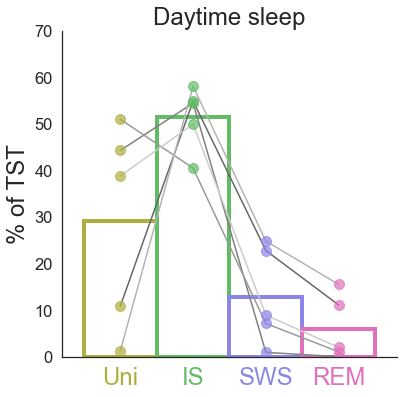

In [31]:
plt.figure(figsize=figsize)
stages_to_plot = ['U (% TST)', 'I (% TST)', 'S (% TST)', 'R (% TST)']


# Line plot of each bird
for bird in range(nBirds):
    bird_stage_proportions = np.ndarray.flatten(stageProportions_day_all[bird][stages_to_plot].values)
    plt.plot([1,2,3,4], bird_stage_proportions*100,
             color=colors_birds[bird]) 
    
num=1
for st in stages_to_plot:
    # Line plot of each bird
    plt.plot(num, stageProportions_by_stage[st]*100,
             marker=marker, markersize=markersize,
             color=colors[2:6][num-1], alpha=linealpha)
    
    # Bar graph of mean
    plt.bar(num, Means[st]*100, width=1, color='none', edgecolor=colors[2:6][num-1], linewidth=bar_linewidth)
    
    num=num+1
    
plt.ylim(-.05, 70)
plt.xlim(0.2,4.8)
plt.ylabel('% of TST', fontsize=axis_label_fontsize)
plt.xticks([1, 2, 3, 4], ['Uni', 'IS', 'SWS', 'REM'],fontsize=axis_label_fontsize)
ax = plt.gca()
[t.set_color(i) for (i,t) in zip(colors[2:6],ax.xaxis.get_ticklabels())]

plt.title('Daytime sleep', fontsize=axis_label_fontsize)
sns.despine()
    
if savePlots:
        plt.savefig(saveAsPath + saveAsName + "Fig2f_Daytime_percentTST.pdf")

In [32]:
Means[['U (% TST)', 'I (% TST)', 'S (% TST)', 'R (% TST)']]*100

,U (% TST),I (% TST),S (% TST),R (% TST)
0,29.326954,51.65589,13.004512,6.012644


In [33]:
SDs[['U (% TST)', 'I (% TST)', 'S (% TST)', 'R (% TST)']]*100

,U (% TST),I (% TST),S (% TST),R (% TST)
0,21.875308,6.841728,10.397065,6.957563


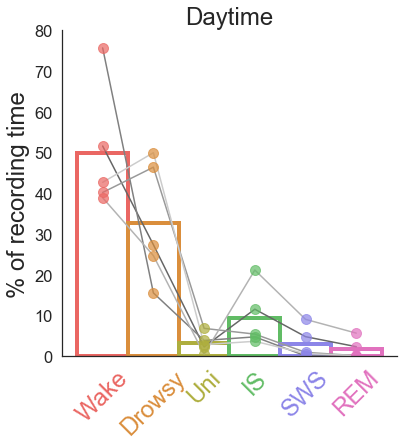

In [34]:
plt.figure(figsize=figsize)

stages_to_plot = [0,1,2,3,4,5]

# Line plot of each bird
for bird in range(nBirds):
    bird_stage_proportions = np.ndarray.flatten(stageProportions_day_all[bird][stages_to_plot].values)
    plt.plot([1,2,3,4,5,6], bird_stage_proportions*100,
             color=colors_birds[bird]) 

num=1
for st in stages_to_plot:
    # Line plot of each bird
    plt.plot(num, stageProportions_by_stage[st]*100,
             marker=marker, markersize=markersize,
             color=colors[num-1], alpha=linealpha)
    
    # Bar graph of mean
    plt.bar(num, Means[st]*100, width=1, color='none', edgecolor=colors[num-1], linewidth=bar_linewidth)
    
    num=num+1
    
plt.ylim(-.05, 80)
plt.xlim(.2, 6.8)
plt.ylabel('% of recording time', fontsize=axis_label_fontsize)
plt.xticks([1, 2, 3, 4, 5, 6], ['Wake', 'Drowsy', 'Uni', 'IS', 'SWS', 'REM'], fontsize=axis_label_fontsize,rotation=45)

ax = plt.gca()
[t.set_color(i) for (i,t) in zip(colors,ax.xaxis.get_ticklabels())]

plt.title('Daytime', fontsize=axis_label_fontsize)
sns.despine()
    
if savePlots:
        plt.savefig(saveAsPath + saveAsName + "Fig2e-g_Daytime_percentTime.pdf")

In [35]:
Means[[0,1,2,3,4,5]]*100

,0,1,2,3,4,5
0,49.816772,32.797475,3.271364,9.316661,3.116272,1.667476


In [36]:
SDs[[0,1,2,3,4,5]]*100

,0,1,2,3,4,5
0,15.285227,14.76548,2.347364,7.29495,3.807308,2.444664


In [37]:
Means['TST']*100

0    17.371773
Name: TST, dtype: float64

In [38]:
SDs['TST']*100

0    11.887459
Name: TST, dtype: float64

## STATS: NIGHTTIME TST vs DAYTIME

In [39]:
AllStageProportions_by_stage['day']['TST']

,Bird 1,Bird 2,Bird 3,Bird 4,Bird 5
0,0.210026,0.087323,0.133997,0.363763,0.07348


In [40]:
AllStageProportions_by_stage['night']['TST']

,Bird 1,Bird 2,Bird 3,Bird 4,Bird 5
0,0.769854,0.79242,0.942492,0.797755,0.844093


In [41]:
stat.ttest_rel(AllStageProportions_by_stage['night']['TST'].iloc[0].values,
               AllStageProportions_by_stage['day']['TST'].iloc[0].values)

Ttest_relResult(statistic=9.39764065279464, pvalue=0.0007144691741019303)

## STATS: Compare day vs night

In [42]:
for stage in [0, 1, 2, 3, 4, 5, 'TST', 'U (% TST)', 'I (% TST)', 'S (% TST)', 'R (% TST)']:
    print('DAY - NIGHT')
    print(stage, '____________________________')
    print('\t', stat.ttest_rel(AllStageProportions_by_stage['day'][stage].iloc[0].values,
                               AllStageProportions_by_stage['night'][stage].iloc[0].values))

DAY - NIGHT
0 ____________________________
	 Ttest_relResult(statistic=6.24701212854557, pvalue=0.003347248832131518)
DAY - NIGHT
1 ____________________________
	 Ttest_relResult(statistic=3.965278232533587, pvalue=0.016604127562052068)
DAY - NIGHT
2 ____________________________
	 Ttest_relResult(statistic=3.110754285606991, pvalue=0.035845713070929944)
DAY - NIGHT
3 ____________________________
	 Ttest_relResult(statistic=-4.678713179601741, pvalue=0.009456763091659328)
DAY - NIGHT
4 ____________________________
	 Ttest_relResult(statistic=-6.541935669500883, pvalue=0.002821829235490779)
DAY - NIGHT
5 ____________________________
	 Ttest_relResult(statistic=-6.030600884714473, pvalue=0.0038107860678242176)
DAY - NIGHT
TST ____________________________
	 Ttest_relResult(statistic=-9.39764065279464, pvalue=0.0007144691741019303)
DAY - NIGHT
U (% TST) ____________________________
	 Ttest_relResult(statistic=2.9977026656411843, pvalue=0.04003257321678277)
DAY - NIGHT
I (% TST) ____________

# Entire 24 hrs

In [43]:
stageProportions_all = {}

for b in range(nBirds):

    stageProportions = DataFrame([], columns=range(len(stages)))

    b_name = 'Bird ' + str(b+1) 
    Scores = AllScores[b_name]

    bn_scores = Scores
    bn_stage_frequencies = bn_scores['Label (#)'].value_counts(normalize=True,sort=False)
                
    stageProportions = stageProportions.append(bn_stage_frequencies, ignore_index=True)
    
    # Replace NaNs with 0
    stageProportions = stageProportions.fillna(0)
    
    # Calc TST and sleep stages as % TST
    
    stageProportions['TST'] = stageProportions[[2,3,4,5]].sum(axis=1)

    stageProportions['U (% TST)'] = stageProportions[2]/stageProportions['TST']
    stageProportions['I (% TST)'] = stageProportions[3]/stageProportions['TST']
    stageProportions['S (% TST)'] = stageProportions[4]/stageProportions['TST']
    stageProportions['R (% TST)'] = stageProportions[5]/stageProportions['TST']

    # Add to dictionary
    stageProportions_all[b] = stageProportions
    

### Organize proportions by stage

In [44]:
stageProportions_by_stage = {}

stage_labels = stageProportions_all[0].columns.values

for st in stage_labels:
    stageProportions_stage = DataFrame([])
    
    for b in range(nBirds):
        stageProportions_bird = stageProportions_all[b]
        stageProportions_stage['Bird ' + str(b+1)] = stageProportions_bird[st]
        
    stageProportions_by_stage[st] = stageProportions_stage

## Find means and SDs

In [45]:
Means = DataFrame([])
SDs = DataFrame([])

for st in stage_labels:
    tmp_mean = stageProportions_by_stage[st].mean(axis=1)
    tmp_sd = stageProportions_by_stage[st].std(axis=1)
    
    Means[st] = tmp_mean
    SDs[st] = tmp_sd
    

## Bar graphs: Plot each stage

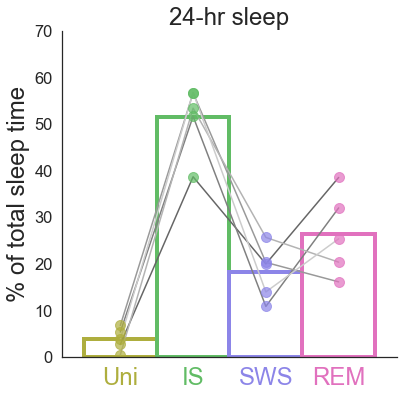

In [46]:
plt.figure(figsize=figsize)
stages_to_plot = ['U (% TST)', 'I (% TST)', 'S (% TST)', 'R (% TST)']

# Line plot of each bird
for bird in range(nBirds):
    bird_stage_proportions = np.ndarray.flatten(stageProportions_all[bird][stages_to_plot].values)
    plt.plot([1,2,3,4], bird_stage_proportions*100,
             color=colors_birds[bird]) 

num=1
for st in stages_to_plot:
    # Line plot of each bird
    plt.plot(num, stageProportions_by_stage[st]*100,
             marker=marker, markersize=markersize,
             color=colors[2:6][num-1], alpha=linealpha)
    
    # Bar graph of mean
    plt.bar(num, Means[st]*100, width=1, color='none', edgecolor=colors[2:6][num-1], linewidth=bar_linewidth)
    
    num=num+1
    
plt.ylim(-.05, 70)
plt.xlim(.2,4.8)
plt.ylabel('% of total sleep time', fontsize=axis_label_fontsize)
plt.xticks([1, 2, 3, 4], ['Uni', 'IS', 'SWS', 'REM'],fontsize=axis_label_fontsize)
ax = plt.gca()
[t.set_color(i) for (i,t) in zip(colors[2:6],ax.xaxis.get_ticklabels())]

plt.title('24-hr sleep', fontsize=axis_label_fontsize)
sns.despine()
    
if savePlots:
        plt.savefig(saveAsPath + saveAsName + "Fig2e-g_24hrs_percentTST.pdf")

In [47]:
Means[['U (% TST)', 'I (% TST)', 'S (% TST)', 'R (% TST)']]*100

,U (% TST),I (% TST),S (% TST),R (% TST)
0,3.829494,51.480847,18.179835,26.509824


In [48]:
SDs[['U (% TST)', 'I (% TST)', 'S (% TST)', 'R (% TST)']]*100

,U (% TST),I (% TST),S (% TST),R (% TST)
0,2.43216,7.459951,5.816198,8.973995


### FIGURE 2G

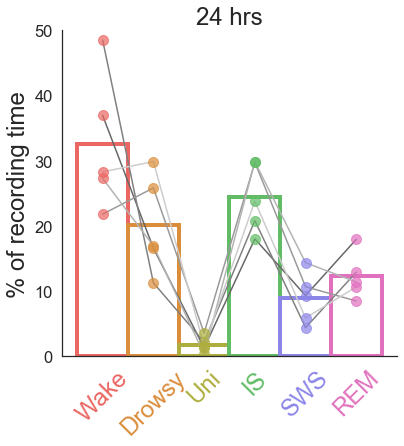

In [49]:
plt.figure(figsize=figsize)

stages_to_plot = [0,1,2,3,4,5]


# Line plot of each bird
for bird in range(nBirds):
    bird_stage_proportions = np.ndarray.flatten(stageProportions_all[bird][stages_to_plot].values)
    plt.plot([1,2,3,4,5,6], bird_stage_proportions*100,
             color=colors_birds[bird]) 

num=1
for st in stages_to_plot:
    # Line plot of each bird
    plt.plot(num, stageProportions_by_stage[st]*100,
             marker=marker, markersize=markersize,
             color=colors[num-1], alpha=linealpha)
    
    # Bar graph of mean
    plt.bar(num, Means[st]*100, width=1, color='none', edgecolor=colors[num-1], linewidth=bar_linewidth)
    
    num=num+1
    
plt.ylim(-.05, 50)
plt.xlim(.2, 6.8)
plt.ylabel('% of recording time', fontsize=axis_label_fontsize)
plt.xticks([1, 2, 3, 4, 5, 6], ['Wake', 'Drowsy', 'Uni', 'IS', 'SWS', 'REM'], fontsize=axis_label_fontsize,rotation=45)

ax = plt.gca()
[t.set_color(i) for (i,t) in zip(colors,ax.xaxis.get_ticklabels())]

plt.title('24 hrs', fontsize=axis_label_fontsize)
sns.despine()
    
if savePlots:
        plt.savefig(saveAsPath + saveAsName + "Fig2g_24hrs_percentTime.pdf")

In [50]:
Means[[0,1,2,3,4,5]]*100

,0,1,2,3,4,5
0,32.553588,20.08662,1.766526,24.423608,8.903956,12.257252


In [51]:
SDs[[0,1,2,3,4,5]]*100

,0,1,2,3,4,5
0,10.435087,7.561011,1.214415,5.293127,3.953845,3.549138


In [52]:
Means['TST']*100

0    47.351343
Name: TST, dtype: float64

In [53]:
SDs['TST']*100

0    6.679177
Name: TST, dtype: float64

In [54]:
stageProportions_by_stage['TST']

,Bird 1,Bird 2,Bird 3,Bird 4,Bird 5
0,0.46478,0.402284,0.523929,0.557988,0.418587


# Save to csv

In [82]:
if saveData:
    fig = 'Fig2e'
    stageProportions = pd.DataFrame([])
    for bird in range(nBirds):
        tmp = stageProportions_night_all[bird] # nighttime
        stageProportions = stageProportions.append(tmp, sort=False)
    stageProportions.to_csv(saveAsPath + saveAsName + fig + '.csv')
        
if saveData:
    fig = 'Fig2f'
    stageProportions = pd.DataFrame([])
    for bird in range(nBirds):
        tmp = stageProportions_day_all[bird] # daytime
        stageProportions = stageProportions.append(tmp, sort=False)
    stageProportions.to_csv(saveAsPath + saveAsName + fig + '.csv')
    
if saveData:
    fig = 'Fig2g'
    stageProportions = pd.DataFrame([])
    for bird in range(nBirds):
        tmp = stageProportions_all[bird] # all
        stageProportions = stageProportions.append(tmp, sort=False)
    stageProportions.to_csv(saveAsPath + saveAsName + fig + '.csv')
        
        